In [1]:
import itertools
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn import linear_model
import time
import matplotlib.pyplot as plt

In [2]:
# import Fall training data with all features
data = pickle.load(open('final_dataset_18fall.p',"rb"))

In [3]:
del data['classes']

In [4]:
#split training data to four folds
train_1 = data[(data['week_n']==3)|(data['week_n']==4)|(data['week_n']==5)|(data['week_n']==6)|(data['week_n']==7)]
train_2 = pd.concat([train_1,data[(data['week_n']==8)]])
train_3 = pd.concat([train_2,data[(data['week_n']==9)]])
train_4 = pd.concat([train_3,data[(data['week_n']==10)]])
test_1 = data[(data['week_n']==8)]
test_2 = data[(data['week_n']==9)]
test_3 = data[(data['week_n']==10)]
test_4 = data[(data['week_n']==11)|(data['week_n']==13)|(data['week_n']==15)]

In [5]:
# Create input variables and output variables
x_train_1 = train_1[train_1.columns.difference(['sales','item_name'])]
x_train_2 = train_2[train_2.columns.difference(['sales','item_name'])]
x_train_3 = train_3[train_3.columns.difference(['sales','item_name'])]
x_train_4 = train_4[train_4.columns.difference(['sales','item_name'])]
x_test_1 = test_1[test_1.columns.difference(['sales','item_name'])]
x_test_2 = test_2[test_2.columns.difference(['sales','item_name'])]
x_test_3 = test_3[test_3.columns.difference(['sales','item_name'])]
x_test_4 = test_4[test_4.columns.difference(['sales','item_name'])]
y_train_1 = train_1[['sales']]
y_train_2 = train_2[['sales']]
y_train_3 = train_3[['sales']]
y_train_4 = train_4[['sales']]
y_test_1 = test_1[['sales']]
y_test_2 = test_2[['sales']]
y_test_3 = test_3[['sales']]
y_test_4 = test_4[['sales']]

In [6]:
x_train = [x_train_1,x_train_2,x_train_3,x_train_4]
y_train = [y_train_1,y_train_2,y_train_3,y_train_4]
x_test = [x_test_1,x_test_2,x_test_3,x_test_4]
y_test = [y_test_1,y_test_2,y_test_3,y_test_4]

## Model1: All products + Linear Model

In [7]:
start = time.time()
#conduct best subset selection with 4-fold cross validation
#store 3 kinds of metrics in perdormance dictionary({variable combination:[metric_1,metric_2,metric_3,mae_of_fold_4]})
predictorcols = x_train_1.columns.difference(['Cycle__1'])
performance = dict()
for k in range(1,len(predictorcols)+1):
    for variables in itertools.combinations(predictorcols, k):
        r2 = []
        mae = []
        larg10 = []
        for i in range(4):
            model = linear_model.LinearRegression()
            model.fit(x_train[i][list(variables)],np.ravel(y_train[i]))
            y_pred = model.predict(x_test[i][list(variables)])
            mae_fold = mean_absolute_error(np.ravel(y_test[i]), y_pred)
            r2_fold = r2_score(np.ravel(y_test[i]), y_pred)
            larg_than_10 = np.sum(np.absolute(y_pred - np.ravel(y_test[i])) > 10)
            mae.append(mae_fold)
            r2.append(r2_fold)
            larg10.append(larg_than_10)
        performance[variables] = [np.mean(mae[:-1]),np.mean(r2[:-1]),np.mean(larg10[:-1]),mae_fold]

end = time.time()

Find the best model according to different kinds of metrics

Format of metrics: [mean absolute error, R2, number of difference>10, mae of fold4]

(mae for fold 4 is a little bit special due to its larger size.)

In [8]:
# The following cells test which sellout threshold gives best model performance

In [14]:
print('Best variable combination based on mae(sellout 75%): ',min(performance.items(), key=lambda x: x[1][0])[0],'\n','\t\t\tMetrics:',
      min(performance.items(), key=lambda x: x[1][0])[1])

Best variable combination based on mae(sellout 75%):  ('avg_over_last_3_cycles', 'exam', 'last_2_week_sales', 'n_users', 'sellout*2_week_lag') 
 			Metrics: [3.4115870929308887, 0.4789922956089023, 0.3333333333333333, 5.982945001598746]


In [55]:
print('Best variable combination based on mae(sellout 50%): ',min(performance.items(), key=lambda x: x[1][0])[0],'\n','\t\t\tMetrics:',
      min(performance.items(), key=lambda x: x[1][0])[1])

Best variable combination based on mae(sellout 50%):  ('Cycle__2', 'avg_over_last_3_cycles', 'exam', 'last_2_week_sales', 'n_users', 'sellout', 'sellout*2_week_lag', 'sports') 
 			Metrics: [3.4534213985869164, 0.45769349655287583, 0.6666666666666666, 5.502581869148357]


In [9]:
print('Best variable combination based on mae: ',min(performance.items(), key=lambda x: x[1][0])[0],'\n','\t\t\tMetrics:',
      min(performance.items(), key=lambda x: x[1][0])[1])

Best variable combination based on mae:  ('avg_over_last_3_cycles', 'exam', 'last_2_week_sales', 'n_users', 'sellout*2_week_lag') 
 			Metrics: [3.4115870929308887, 0.4789922956089023, 0.3333333333333333, 5.982945001598746]


In [69]:
print('Best variable combination based on R2(sellout 75%): ',max(performance.items(), key=lambda x: x[1][1])[0],'\n','\t\t\tMetrics:',
      max(performance.items(), key=lambda x: x[1][1])[1])

Best variable combination based on R2(sellout 75%):  ('Cycle__2', 'avg_over_last_3_cycles', 'last_2_week_sales', 'n_users', 'sellout*2_week_lag') 
 			Metrics: [3.4236487953439916, 0.49180265802714135, 0.3333333333333333, 5.48957870504419]


In [56]:
print('Best variable combination based on R2(sellout 50%): ',max(performance.items(), key=lambda x: x[1][1])[0],'\n','\t\t\tMetrics:',
      max(performance.items(), key=lambda x: x[1][1])[1])

Best variable combination based on R2(sellout 50%):  ('Cycle__2', 'avg_over_last_3_cycles', 'exam', 'last_2_week_sales', 'n_users', 'sellout*2_week_lag', 'sports') 
 			Metrics: [3.4789715843346234, 0.4594307957551485, 0.6666666666666666, 5.487739104167931]


In [18]:
print('Best variable combination based on R2: ',max(performance.items(), key=lambda x: x[1][1])[0],'\n','\t\t\tMetrics:',
      max(performance.items(), key=lambda x: x[1][1])[1])

Best variable combination based on R2:  ('avg_over_last_3_cycles', 'exam', 'n_users', 'sellout', 'sellout*2_week_lag') 
 			Metrics: [3.5726341566972564, 0.44741703448334613, 0.6666666666666666, 5.966942145570153]


In [70]:
print('Best variable combination based on # of difference>10(sellout 75%): ',min(performance.items(), key=lambda x: x[1][2])[0],'\n','\t\t\t\t\tMetrics:',
      min(performance.items(), key=lambda x: x[1][2])[1])

Best variable combination based on # of difference>10(sellout 75%):  ('last_2_week_sales', 'sellout') 
 					Metrics: [3.706985935290396, 0.44008712184536236, 0.3333333333333333, 6.363658983697315]


In [57]:
print('Best variable combination based on # of difference>10(sellout 50%): ',min(performance.items(), key=lambda x: x[1][2])[0],'\n','\t\t\t\t\tMetrics:',
      min(performance.items(), key=lambda x: x[1][2])[1])

Best variable combination based on # of difference>10(sellout 50%):  ('avg_over_last_3_cycles', 'sellout*2_week_lag') 
 					Metrics: [3.915111180155558, 0.3706868974047716, 0.3333333333333333, 7.825421601204918]


In [19]:
print('Best variable combination based on # of difference>10: ',min(performance.items(), key=lambda x: x[1][2])[0],'\n','\t\t\t\t\tMetrics:',
      min(performance.items(), key=lambda x: x[1][2])[1])

Best variable combination based on # of difference>10:  ('avg_over_last_3_cycles', 'sellout', 'sellout*2_week_lag') 
 					Metrics: [3.6768766621230053, 0.4197129290412293, 0.3333333333333333, 6.3524486386301415]


In [13]:
performance[('Cycle__2', 'avg_over_last_3_cycles', 'exam', 'last_2_week_sales', 'n_users', 'sellout*2_week_lag', 'week_n')]

[3.5012530856476674, 0.4465036923855397, 0.3333333333333333, 5.421660489652737]

In [134]:
# 75% threshold with the following features gives the best model performance on Fall data
performance[('Cycle__2', 'avg_over_last_3_cycles','exam','last_2_week_sales', 'n_users', 'sellout*2_week_lag')]

[3.412754094184842, 0.4842264523141308, 0.3333333333333333, 5.407145343784352]

## Model1: Test with 19Spring

In [32]:
spring = pickle.load(open('final_dataset_19spring_week8.p',"rb" ))

In [33]:
sellout = pd.read_pickle('C:/Users/Baoyp/Documents/2019 Spring/GU project/sellout/sellout_df_spring19.pkl')
sellout = sellout[sellout['week_n']!=0]
sellout['ref_week_n'] = sellout['week_n']+2
del sellout['week_n']
sellout = sellout.rename(columns={'ref_week_n':'week_n'})
#sellout = sellout[sellout['week_n']!=8]
del sellout['sellout']

In [34]:
spring['cycle_n'] = np.where(spring['Cycle__1']==1,1, np.where(spring['Cycle__2']==1,2,3))
spring = pd.merge(spring,sellout,how='left')
spring = spring.drop('cycle_n',axis=1)
spring= spring.rename(columns = {'75_percent':'sellout'})
spring['sellout*2_week_lag']=spring['last_2_week_sales']*spring['sellout']
spring = spring[['week_n', 'sales', 'last_2_week_sales', 'classes', 'exam', 'sports',
       'Cycle__1', 'Cycle__2', 'Cycle__3', 'n_users', 'avg_over_last_3_cycles','sellout','sellout*2_week_lag',
       'item_name']]

In [36]:
del spring['classes']
del spring['Cycle__1']

In [37]:
fall = pickle.load(open('final_dataset_18fall.p',"rb"))

In [38]:
del fall['classes']
del fall['Cycle__1']

In [43]:
spring = spring[(spring['week_n']!=7 )& (spring['week_n']!=8)]

In [44]:
predictorcols = fall.columns.difference(['sales','item_name'])
#['Cycle__2','avg_over_last_3_cycles', 'last_2_week_sales', 'n_users','Cycle__3','sports','week_n','sellout','sellout*2_week_lag']
performance = dict()
for k in range(1,len(predictorcols)+1):
    for variables in itertools.combinations(predictorcols, k):
        r2 = []
        mae = []
        larg10 = []
        X = fall[list(variables)]
        Y = fall[['sales']]
        X_test = spring[list(variables)]
        Y_test = spring[['sales']]
        model = linear_model.LinearRegression()
        model.fit(X,np.ravel(Y))
        Y_pred = model.predict(X_test)
        mae = mean_absolute_error(np.ravel(Y_test), Y_pred)
        r2 = r2_score(np.ravel(Y_test), Y_pred)
        larg_than_10 = np.sum(np.absolute(Y_pred - np.ravel(Y_test)) > 10)
        performance[variables] = [mae,r2,larg_than_10]

In [ ]:
# Test different sellout thresholds on Spring data: use Fall as train set, Spring as test set

In [45]:
print('75%')
print('Best variable combination based on mae: ',min(performance.items(), key=lambda x: x[1][0])[0],'\n','\t\t\tMetrics:',
      min(performance.items(), key=lambda x: x[1][0])[1])

print('Best variable combination based on R2: ',max(performance.items(), key=lambda x: x[1][1])[0],'\n','\t\t\tMetrics:',
      max(performance.items(), key=lambda x: x[1][1])[1])

print('Best variable combination based on # of difference>10: ',min(performance.items(), key=lambda x: x[1][2])[0],'\n','\t\t\t\t\tMetrics:',
      min(performance.items(), key=lambda x: x[1][2])[1])

75%
Best variable combination based on mae:  ('Cycle__2', 'avg_over_last_3_cycles', 'exam', 'last_2_week_sales', 'n_users', 'sellout*2_week_lag', 'week_n') 
 			Metrics: [3.6832268643859396, 0.4982668365139381, 40]
Best variable combination based on R2:  ('Cycle__2', 'avg_over_last_3_cycles', 'exam', 'last_2_week_sales', 'n_users', 'sellout*2_week_lag', 'week_n') 
 			Metrics: [3.6832268643859396, 0.4982668365139381, 40]
Best variable combination based on # of difference>10:  ('Cycle__2', 'avg_over_last_3_cycles', 'last_2_week_sales') 
 					Metrics: [4.04995484189953, 0.4128283066940581, 20]


In [107]:
print('50%')
print('Best variable combination based on mae: ',min(performance.items(), key=lambda x: x[1][0])[0],'\n','\t\t\tMetrics:',
      min(performance.items(), key=lambda x: x[1][0])[1])

print('Best variable combination based on R2: ',max(performance.items(), key=lambda x: x[1][1])[0],'\n','\t\t\tMetrics:',
      max(performance.items(), key=lambda x: x[1][1])[1])

print('Best variable combination based on # of difference>10: ',min(performance.items(), key=lambda x: x[1][2])[0],'\n','\t\t\t\t\tMetrics:',
      min(performance.items(), key=lambda x: x[1][2])[1])

50%
Best variable combination based on mae:  ('Cycle__2', 'avg_over_last_3_cycles', 'last_2_week_sales', 'n_users', 'Cycle__3', 'week_n', 'sellout*2_week_lag') 
 			Metrics: [3.712099080595953, 0.49675474421227794, 50]
Best variable combination based on R2:  ('Cycle__2', 'avg_over_last_3_cycles', 'last_2_week_sales', 'n_users', 'Cycle__3') 
 			Metrics: [3.721134055632399, 0.4972306159851153, 30]
Best variable combination based on # of difference>10:  ('Cycle__2', 'avg_over_last_3_cycles', 'last_2_week_sales') 
 					Metrics: [4.049954841899531, 0.41282830669405823, 20]


## Model2: All products + Poisson GLM

In [31]:
start = time.time()
#conduct best subset selection with 4-fold cross validation
#store 3 kinds of metrics in perdormance dictionary({variable combination:[metric_1,metric_2,metric_3,mae_of_fold_4]})
predictorcols = x_train_1.columns
performance = dict()
for k in range(1,len(predictorcols)+1):
    for variables in itertools.combinations(predictorcols, k):
        r2 = []
        mae = []
        larg10 = []
        for i in range(4):
            df=x_train[i]
            df.exog=x_train[i][list(variables)]
            #df.exog = sm.add_constant(df.exog)
            df.endog=y_train[i]
            poisson_model = sm.GLM(df.endog, df.exog, family=sm.families.Poisson())
            poisson_results = poisson_model.fit()
            df_test = x_test[i][list(variables)]
            #df_test = sm.add_constant(df_test)
            y_pred = poisson_results.predict(df_test)
            mae_fold = mean_absolute_error(np.ravel(y_test[i]), y_pred)
            r2_fold = r2_score(np.ravel(y_test[i]), y_pred)
            larg_than_10 = np.sum(np.absolute(y_pred - np.ravel(y_test[i])) > 10)
            mae.append(mae_fold)
            r2.append(r2_fold)
            larg10.append(larg_than_10)
        performance[variables] = [np.mean(mae),np.mean(r2),np.mean(larg10),mae_fold]

end = time.time()

Find the best model according to different kinds of metrics

Format of metrics: [mean absolute error, R2, number of difference>10, mae of fold4]

(mae for fold 4 is a little bit special due to its larger size.)

In [33]:
print('Best variable combination based on mae: ',min(performance.items(), key=lambda x: x[1][0])[0],'\n','\t\t\tMetrics:',
      min(performance.items(), key=lambda x: x[1][0])[1])

Best variable combination based on mae:  ('Cycle__1', 'avg_over_last_3_cycles', 'classes', 'exam', 'last_2_week_sales', 'n_users') 
 			Metrics: [4.120925754243929, 0.422803800089679, 2.5, 5.463406123024092]


In [34]:
print('Best variable combination based on R2: ',max(performance.items(), key=lambda x: x[1][1])[0],'\n','\t\t\tMetrics:',
      max(performance.items(), key=lambda x: x[1][1])[1])

Best variable combination based on R2:  ('Cycle__1', 'avg_over_last_3_cycles', 'classes', 'exam', 'last_2_week_sales', 'n_users', 'sports') 
 			Metrics: [4.129803936377439, 0.42652371680150414, 2.5, 5.46488118112247]


In [35]:
print('Best variable combination based on # of difference>10: ',min(performance.items(), key=lambda x: x[1][2])[0],'\n','\t\t\t\t\tMetrics:',
      min(performance.items(), key=lambda x: x[1][2])[1])

Best variable combination based on # of difference>10:  ('Cycle__1', 'avg_over_last_3_cycles', 'classes', 'last_2_week_sales', 'n_users') 
 					Metrics: [4.139949132957636, 0.4162859043859951, 2.25, 5.493206470365918]


Compared with linear model, the optimal mae is larger, R^2 is samller. So linear model is better

## Model3: Individual product + Linear Model

In [36]:
#split training data to four folds
def split_kfold(data):
    train_1 = data[(data['week_n']==3)|(data['week_n']==4)|(data['week_n']==5)|(data['week_n']==6)|(data['week_n']==7)]
    train_2 = pd.concat([train_1,data[(data['week_n']==8)]])
    train_3 = pd.concat([train_2,data[(data['week_n']==9)]])
    train_4 = pd.concat([train_3,data[(data['week_n']==10)]])
    test_1 = data[(data['week_n']==8)]
    test_2 = data[(data['week_n']==9)]
    test_3 = data[(data['week_n']==10)]
    test_4 = data[(data['week_n']==11)|(data['week_n']==13)|(data['week_n']==15)]
    x_train_1 = train_1[train_1.columns.difference(['sales','item_name'])]
    x_train_2 = train_2[train_2.columns.difference(['sales','item_name'])]
    x_train_3 = train_3[train_3.columns.difference(['sales','item_name'])]
    x_train_4 = train_4[train_4.columns.difference(['sales','item_name'])]
    x_test_1 = test_1[test_1.columns.difference(['sales','item_name'])]
    x_test_2 = test_2[test_2.columns.difference(['sales','item_name'])]
    x_test_3 = test_3[test_3.columns.difference(['sales','item_name'])]
    x_test_4 = test_4[test_4.columns.difference(['sales','item_name'])]
    y_train_1 = train_1[['sales']]
    y_train_2 = train_2[['sales']]
    y_train_3 = train_3[['sales']]
    y_train_4 = train_4[['sales']]
    y_test_1 = test_1[['sales']]
    y_test_2 = test_2[['sales']]
    y_test_3 = test_3[['sales']]
    y_test_4 = test_4[['sales']]
    x_train = [x_train_1,x_train_2,x_train_3,x_train_4]
    y_train = [y_train_1,y_train_2,y_train_3,y_train_4]
    x_test = [x_test_1,x_test_2,x_test_3,x_test_4]
    y_test = [y_test_1,y_test_2,y_test_3,y_test_4]
    return x_train, y_train, x_test, y_test

In [47]:
def item_lm(itemname):
    data = pickle.load(open('final_dataset_18fall.p',"rb"))
    data = data[data['item_name']==itemname]
    x_train, y_train, x_test, y_test = split_kfold(data)
    predictorcols = x_train[0].columns
    performance = dict()
    for k in range(1,len(predictorcols)+1):
        for variables in itertools.combinations(predictorcols, k):
            r2 = []
            mae = []
            larg10 = []
            for i in range(4):
                model = linear_model.LinearRegression()
                model.fit(x_train[i][list(variables)],np.ravel(y_train[i]))
                y_pred = model.predict(x_test[i][list(variables)])
                mae_fold = mean_absolute_error(np.ravel(y_test[i]), y_pred)
                r2_fold = r2_score(np.ravel(y_test[i]), y_pred)
                larg_than_10 = np.sum(np.absolute(y_pred - np.ravel(y_test[i])) > 10)
                mae.append(mae_fold)
                r2.append(r2_fold)
                larg10.append(larg_than_10)
            performance[variables] = [np.mean(mae),np.mean(r2),np.mean(larg10),mae_fold]
    return performance

In [54]:
item_names = ['Penne alla Vodka', 'Grilled Chicken Bowl','Mac and Cheese','Grilled Chicken Tenders','Seared Steak Bowl','Chicken Bacon Club',
             'BBQ Pulled Pork Plate','Chicken Parm','Smashed Cheeseburger','Build-Your-Own Chicken Tacos']
performances = { i:item_lm(i) for i in item_names}

In [55]:
top10_mae = [min(performances[i].items(), key=lambda x: x[1][0])[1][0] for i in item_names]

In [58]:
np.mean(top10_mae)

3.09964202269961

In [63]:
top10_r2 = [max(performances[i].items(), key=lambda x: x[1][1])[1][1] for i in item_names]
np.mean(top10_r2)

-0.5288154675532135

## Model4: Individual product + Poisson GLM

In [65]:
def item_poisson(itemname):
    data = pickle.load(open('final_dataset_18fall.p',"rb"))
    data = data[data['item_name']==itemname]
    x_train, y_train, x_test, y_test = split_kfold(data)
    predictorcols = x_train[0].columns
    performance = dict()
    for k in range(1,len(predictorcols)+1):
        for variables in itertools.combinations(predictorcols, k):
            r2 = []
            mae = []
            larg10 = []
            for i in range(4):
                df=x_train[i]
                df.exog=x_train[i][list(variables)]
                #df.exog = sm.add_constant(df.exog)
                df.endog=y_train[i]
                poisson_model = sm.GLM(df.endog, df.exog, family=sm.families.Poisson())
                poisson_results = poisson_model.fit()
                df_test = x_test[i][list(variables)]
                #df_test = sm.add_constant(df_test)
                y_pred = poisson_results.predict(df_test)
                mae_fold = mean_absolute_error(np.ravel(y_test[i]), y_pred)
                r2_fold = r2_score(np.ravel(y_test[i]), y_pred)
                larg_than_10 = np.sum(np.absolute(y_pred - np.ravel(y_test[i])) > 10)
                mae.append(mae_fold)
                r2.append(r2_fold)
                larg10.append(larg_than_10)
            performance[variables] = [np.mean(mae),np.mean(r2),np.mean(larg10),mae_fold]
    return performance

In [66]:
item_names = ['Penne alla Vodka', 'Grilled Chicken Bowl','Mac and Cheese','Grilled Chicken Tenders','Seared Steak Bowl','Chicken Bacon Club',
             'BBQ Pulled Pork Plate','Chicken Parm','Smashed Cheeseburger','Build-Your-Own Chicken Tacos']
performances = { i:item_poisson(i) for i in item_names}

C:\Users\Baoyp\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
C:\Users\Baoyp\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()
C:\Users\Baoyp\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
C:\Users\Baoyp\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()
C:\Users\B

C:\Users\Baoyp\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
C:\Users\Baoyp\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()
C:\Users\Baoyp\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
C:\Users\Baoyp\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()
C:\Users\B

C:\Users\Baoyp\Anaconda3\lib\site-packages\statsmodels\regression\_tools.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid


PerfectSeparationError: Perfect separation detected, results not available

## Compare coefficients of full model on 18Spring with model on 18Fall

In [95]:
spring = pickle.load(open('final_dataset_18spring.p',"rb"))
fall = pickle.load(open('final_dataset_18fall.p',"rb"))
spring=spring.drop('n_users',axis=1)
fall=fall.drop('n_users',axis=1)
spring = spring[spring['week_n']>=3]

In [101]:
X = spring[spring.columns.difference(['sales','item_name','Cycle__2'])]
Y = spring[['sales']]
X = sm.add_constant(X)
est = sm.OLS(Y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     33.84
Date:                Sun, 17 Feb 2019   Prob (F-statistic):           1.10e-40
Time:                        21:50:37   Log-Likelihood:                -1405.5
No. Observations:                 410   AIC:                             2829.
Df Residuals:                     401   BIC:                             2865.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -3

In [104]:
X = fall[fall.columns.difference(['sales','item_name','Cycle__2'])]
Y = fall[['sales']]
X = sm.add_constant(X)
est = sm.OLS(Y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     29.73
Date:                Sun, 17 Feb 2019   Prob (F-statistic):           5.10e-30
Time:                        21:50:49   Log-Likelihood:                -804.94
No. Observations:                 268   AIC:                             1626.
Df Residuals:                     260   BIC:                             1655.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

## Fit final linear model on FALL

In [4]:
fall = pickle.load(open('final_dataset_18fall.p',"rb"))
del fall['classes']
del fall['Cycle__1']

In [31]:
X = fall[['Cycle__2', 'avg_over_last_3_cycles', 'exam', 'last_2_week_sales', 'n_users', 'sellout*2_week_lag', 'week_n']]
Y = fall[['sales']]

In [32]:
X = sm.add_constant(X)
est = sm.OLS(Y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     36.77
Date:                Tue, 12 Mar 2019   Prob (F-statistic):           1.52e-35
Time:                        16:30:58   Log-Likelihood:                -791.53
No. Observations:                 268   AIC:                             1599.
Df Residuals:                     260   BIC:                             1628.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     26

In [44]:
pred_df = est2.get_prediction().summary_frame(alpha=0.05)

In [47]:
pred_df.columns

Index(['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper', 'obs_ci_lower',
       'obs_ci_upper'],
      dtype='object')

Text(0.5, 1.0, 'Plot of Residuals')

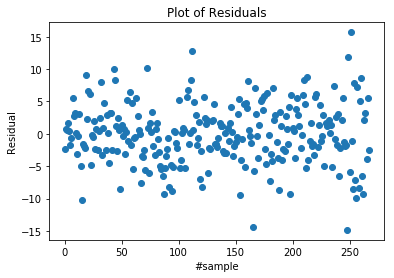

In [41]:
plt.scatter(np.arange(268),residual)
plt.xlabel('#sample')
plt.ylabel('Residual')
plt.title('Plot of Residuals')

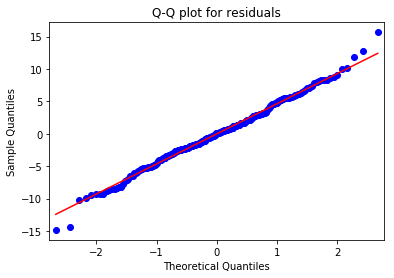

In [35]:
sm.qqplot(residual, line='s')
plt.title('Q-Q plot for residuals')
plt.show()

In [14]:
pickle.dump(est2,open('final_model_stats.p',"wb"))

In [33]:
final_model = linear_model.LinearRegression()
final_model.fit(X,np.ravel(Y))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [56]:
pickle.dump(final_model,open('final_model.p',"wb" ))